# 👖 Variational Autoencoders - Fashion-MNIST


In this notebook, we'll walk through the steps required to train your own autoencoder on the fashion MNIST dataset.

The code has been adapted from the excellent VAE tutorial created by Francois Chollet, available on the Keras website.


In [1]:
import os

import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.stats import norm
from torchvision import datasets
from rich.progress import Progress
from torchvision.transforms import v2
from mpl_toolkits.axes_grid1 import make_axes_locatable

from notebooks.utils import display

## 0. Parameters


In [2]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Let's use CUDA ({gpu_name})")
else:
    device = torch.device('cpu')

Let's use CUDA (NVIDIA RTX 6000 Ada Generation)


## 1. Prepare the data


In [4]:
# Load the data
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Pad([2, 2, 2, 2], padding_mode='constant', fill=0.0),
    ]
)
train_set = datasets.FashionMNIST(root='data', train=True, download=True, transform=transforms)
test_set = datasets.FashionMNIST(root='data', train=False, download=True, transform=transforms)

In [5]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, persistent_workers=True
)

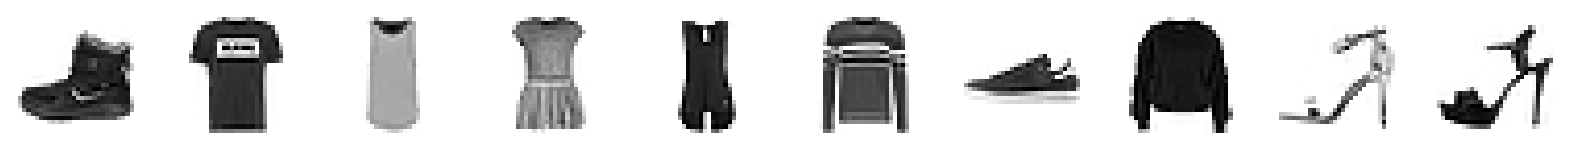

In [6]:
# Show some items of clothing from the training set
x_train = np.array([train_set[i][0] for i in range(10)])
display(x_train)

## 2. Build the variational autoencoder


In [7]:
class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        epsilon = torch.randn_like(z_mean)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

In [8]:
# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(CHANNELS, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Flatten(),
        )
        self.z_mean_head = nn.Linear(128 * 4 * 4, EMBEDDING_DIM)
        self.z_log_var_head = nn.Linear(128 * 4 * 4, EMBEDDING_DIM)

    def forward(self, x):
        x = self.net(x)
        z_mean = self.z_mean_head(x)
        z_log_var = self.z_log_var_head(x)
        return z_mean, z_log_var

In [9]:
# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(EMBEDDING_DIM, 128 * 4 * 4),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, CHANNELS, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.net(x)
        return x

## 3. Train the variational autoencoder


In [10]:
encoder = Encoder().to(device)
sampler = Sampling().to(device)
decoder = Decoder().to(device)
train_parameters = list(encoder.parameters()) + list(decoder.parameters())
opt = torch.optim.Adam(train_parameters, lr=0.0005)

In [11]:
with Progress() as progress:
    ema_total_loss = 0.0
    ema_rec_loss = 0.0
    ema_kl_loss = 0.0
    for epoch in range(EPOCHS):
        train_task = progress.add_task('Training...', total=len(train_loader))
        encoder.train()
        decoder.train()
        for X, _ in train_loader:
            X = X.to(device)
            z_mean, z_log_var = encoder(X)
            z = sampler(z_mean, z_log_var)
            X_hat = decoder(z)
            reconstruction_loss = BETA * F.binary_cross_entropy(X_hat, X)
            kl_loss = torch.mean(-0.5 * torch.sum(1.0 + z_log_var - z_mean**2.0 - torch.exp(z_log_var), dim=1))
            total_loss = reconstruction_loss + kl_loss

            opt.zero_grad()
            total_loss.backward()
            opt.step()

            ema_total_loss = 0.9 * ema_total_loss + 0.1 * total_loss.item()
            ema_rec_loss = 0.9 * ema_rec_loss + 0.1 * reconstruction_loss.item()
            ema_kl_loss = 0.9 * ema_kl_loss + 0.1 * kl_loss.item()
            description = f'[{epoch + 1}/{EPOCHS}] loss: {ema_total_loss:.4f}, rec_loss: {ema_rec_loss:.4f}, kl_loss: {ema_kl_loss:.4f}'

            progress.update(train_task, advance=1, description=description)

    progress.update(train_task, refresh=True)

Output()

In [12]:
os.makedirs('./models', exist_ok=True)
ckpt_dict = {
    'encoder': encoder.state_dict(),
    'decoder': decoder.state_dict(),
    'opt': opt.state_dict(),
}
torch.save(ckpt_dict, './models/vae.pth')

## 3. Reconstruction using the variational autoencoder


In [13]:
# Select a subset of the test set
n_to_predict = 5000
test_subset = torch.utils.data.Subset(test_set, range(n_to_predict))
test_loader = torch.utils.data.DataLoader(
    test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    persistent_workers=True,
)

In [14]:
# Create autoencoder predictions and display
z = []
z_mean = []
z_log_var = []
example_images = []
example_labels = []
reconstructions = []

encoder.eval()
decoder.eval()
for X, y in test_loader:
    example_images.append(X.numpy())
    example_labels.append(y.numpy())

    with torch.no_grad():
        X = X.to(device)
        mu, log_var = encoder(X)
        z_mean.append(mu.detach().cpu().numpy())
        z_log_var.append(log_var.detach().cpu().numpy())

        sample = sampler(mu, log_var)
        z.append(sample.detach().cpu().numpy())

        X_hat = decoder(sample)
        reconstructions.append(X_hat.detach().cpu().numpy())

z = np.concatenate(z, axis=0)
z_mean = np.concatenate(z_mean, axis=0)
z_log_var = np.concatenate(z_log_var, axis=0)
example_images = np.concatenate(example_images, axis=0)
example_labels = np.concatenate(example_labels, axis=0)
reconstructions = np.concatenate(reconstructions, axis=0)

Example real clothing items


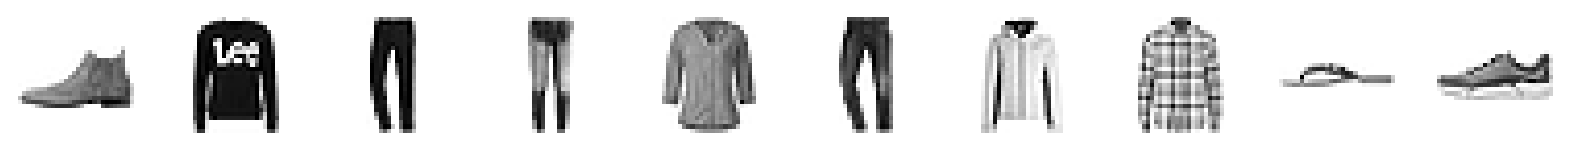

Reconstructions


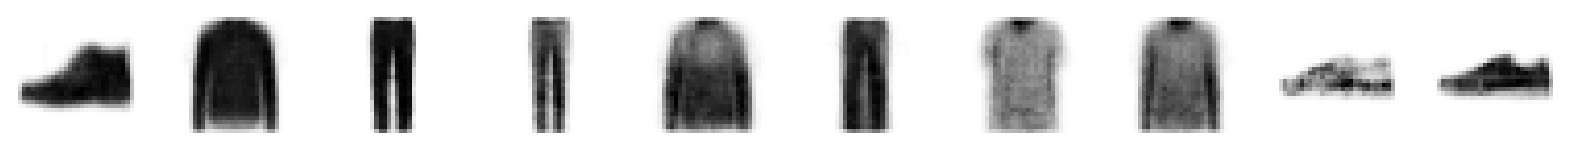

In [15]:
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

## 4. Embed using the encoder


In [16]:
# Some examples of the embeddings
print(z[:10])

[[-1.4764274  -0.47172263]
 [ 0.19468798  1.099597  ]
 [ 2.7640634  -0.07163438]
 [ 1.8230493  -1.4802959 ]
 [ 0.07637687  0.16637923]
 [ 1.5940942  -0.1650813 ]
 [ 0.5236692  -0.70662427]
 [ 0.3121483  -0.23959726]
 [-0.20726365 -2.3986652 ]
 [-1.162459   -2.1323564 ]]


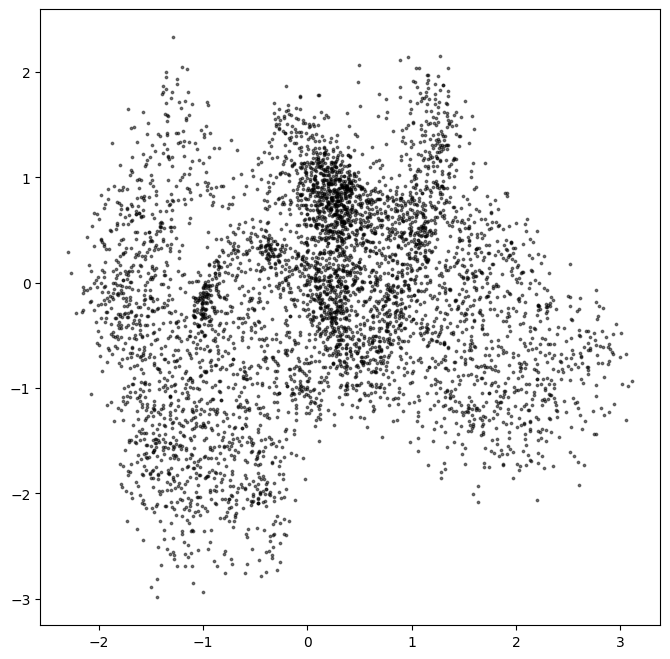

In [17]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 5. Generate using the decoder


In [18]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [19]:
# Decode the sampled points
reconstructions = []
for i in range(0, len(z_sample), BATCH_SIZE):
    i0 = i
    i1 = min(i + BATCH_SIZE, len(z_sample))
    z_batch = torch.Tensor(z_sample[i0:i1]).float().to(device)
    with torch.no_grad():
        X_hat = decoder(z_batch)
        reconstructions.append(X_hat.detach().cpu().numpy())

reconstructions = np.concatenate(reconstructions, axis=0)
reconstructions = np.squeeze(reconstructions, axis=1)

In [20]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

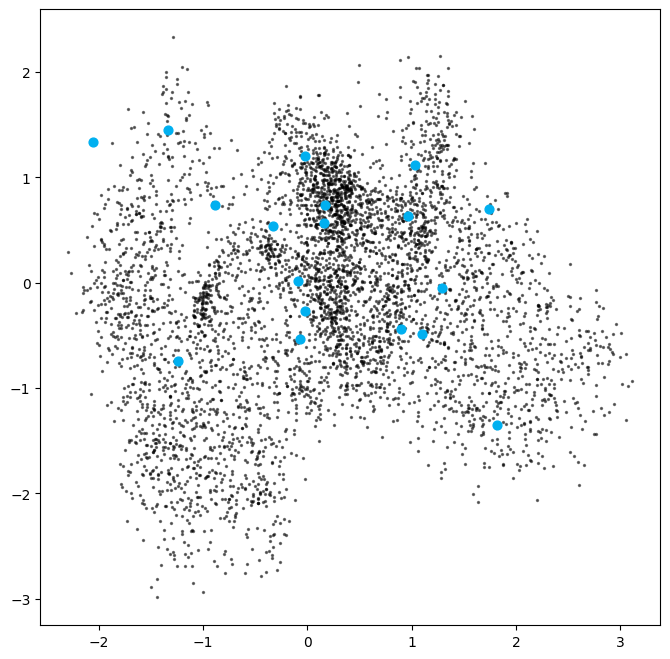

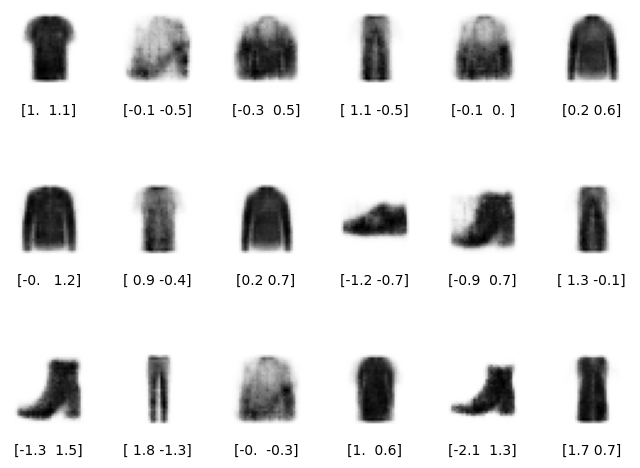

In [21]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## 6. Explore the latent space


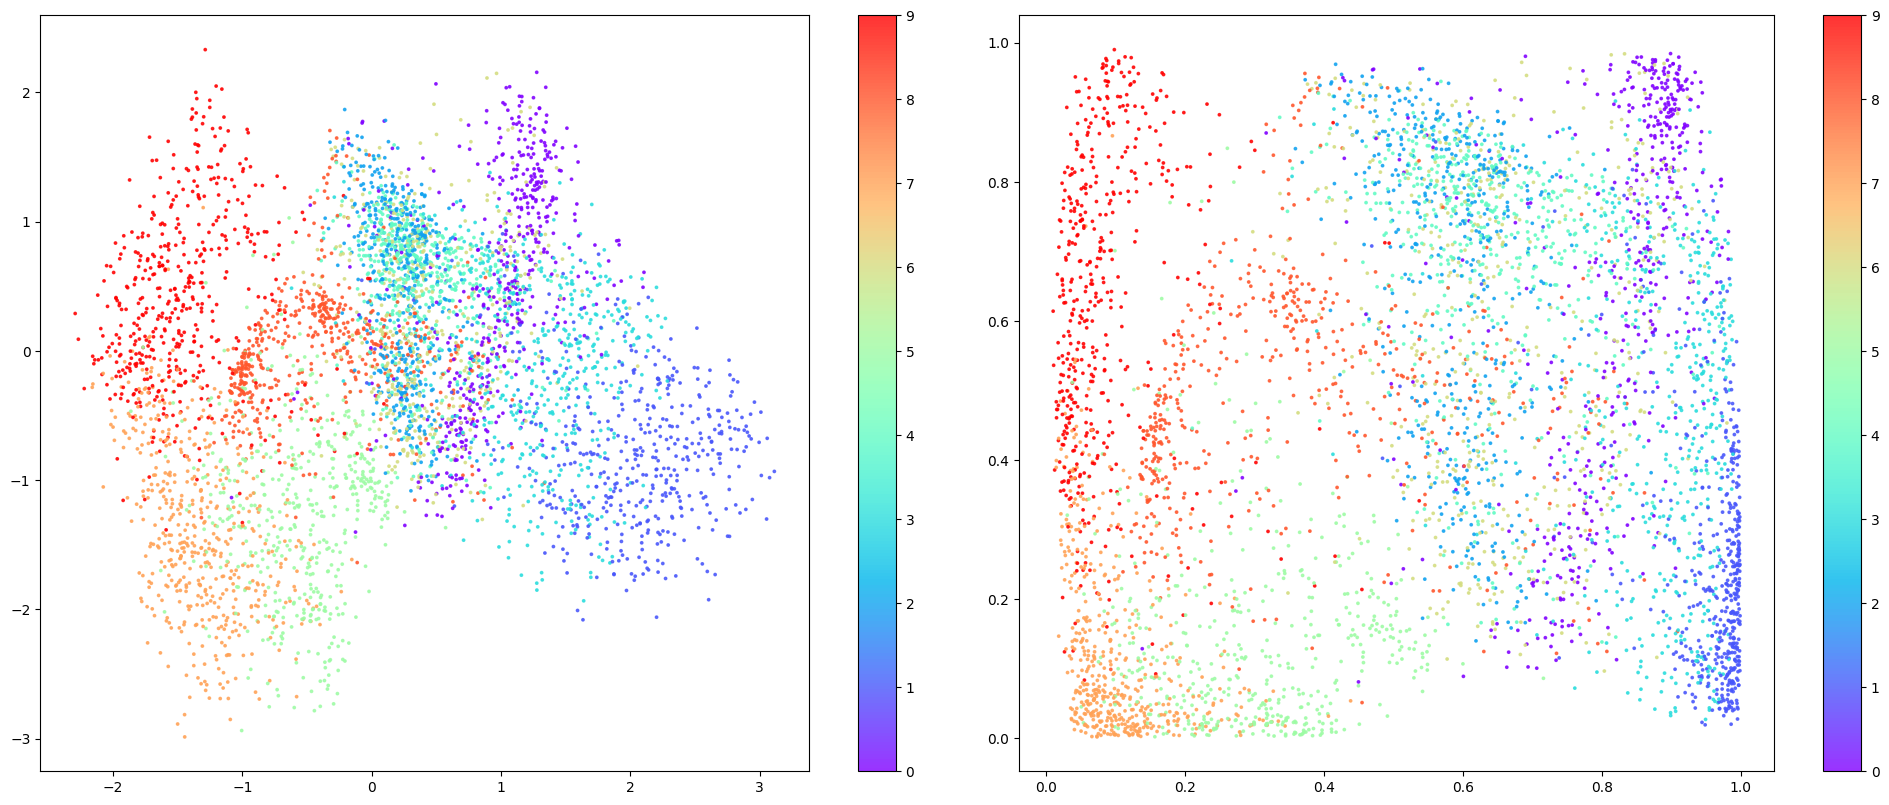

In [22]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2.5, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3)
ax.set_aspect('equal')
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3)
ax.set_aspect('equal')
plt.colorbar(plot_2)
fig.tight_layout()
plt.show()

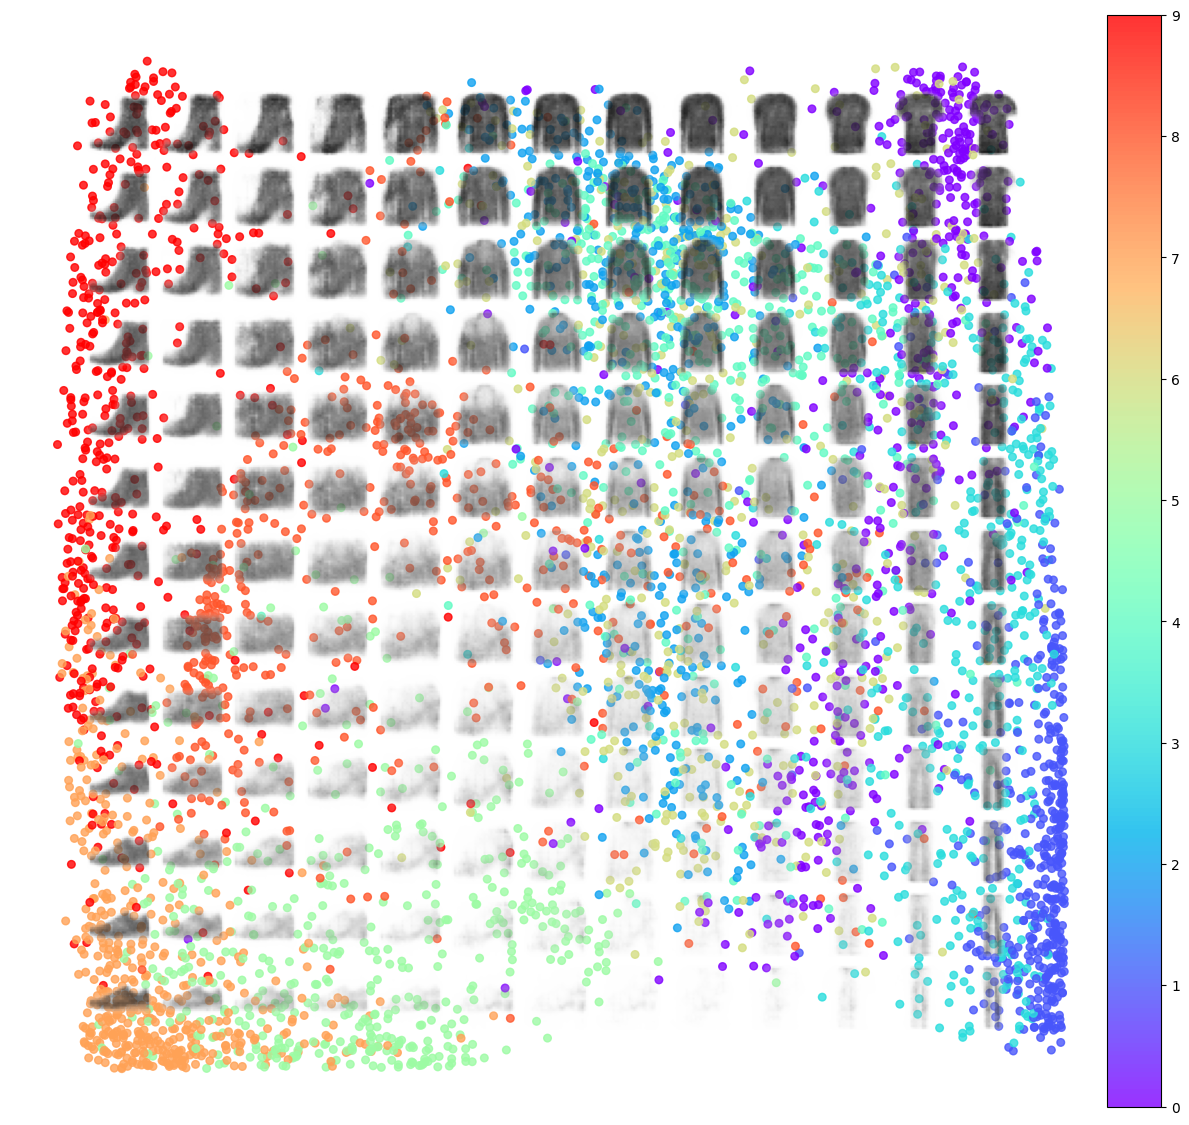

In [23]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
fig, ax = plt.subplots(figsize=(figsize, figsize))
sc = ax.scatter(
    p[:, 0],
    p[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=30,
    zorder=1,
)

# Add a colorbar in a new axis beside the main plot
cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc, cax=cax)

# Show the reconstructions for grid points in the latent space
x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

with torch.no_grad():
    grid_torch = torch.tensor(grid, dtype=torch.float32, device=device)
    reconstructions = decoder(grid_torch)

alpha_channel = reconstructions.clone()
color_channels = 1.0 - reconstructions.repeat(1, 3, 1, 1)
reconstructions = torch.cat([color_channels, alpha_channel], dim=1)
reconstructions = reconstructions.permute(0, 2, 3, 1)
reconstructions = reconstructions.cpu().detach().numpy()

# Create a grid of locations where the reconstructions will be shown
xs = np.linspace(0, 1, grid_size)
ys = np.linspace(1, 0, grid_size)
dx = xs[1] - xs[0]
dy = ys[0] - ys[1]
xx, yy = np.meshgrid(xs, ys, indexing='xy')
grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)

# fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    cx, cy = grid[i]
    ax.imshow(
        reconstructions[i].squeeze(),
        extent=[cx - dx / 2, cx + dx / 2, cy - dy / 2, cy + dy / 2],
        origin="upper",
        zorder=2,
    )
    ax.axis('off')

ax.set_xlim(xs[0] - dx / 2, xs[-1] + dx / 2)
ax.set_ylim(ys[-1] - dy / 2, ys[0] + dy / 2)
ax.set_aspect('equal')
fig.tight_layout()
plt.show()